In [1]:
from KGS import *
import scipp as sc
from TubeMeasurment_mccode import BIFROST_measurement

# DATATREATMENT FOR POWDER - (long name)

In [2]:
#BIFROST_measurement.load_scan('Powder_NAC_test_Ef5_1t','Powder_NAC_data_1t_5Ef_corrected',set_Elim=(-2,2), Correct=True)

In [3]:
settings_1 = np.loadtxt('Powder_NAC_data_1t_5Ef_corrected').T

powder = settings_1 #np.hstack((settings_1,settings_2))

print(len(settings_1[0]))

1528596


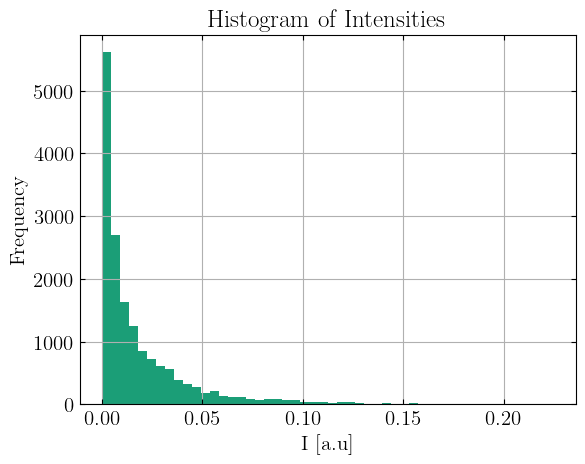

In [4]:
data_flat = powder[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.0001)], bins=50)  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

In [5]:
qx = sc.array(dims=["row"], values=powder[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=powder[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=powder[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(powder[3]**2+powder[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=powder[0], unit="Å^(-1)", variances=powder[1]**2), 
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=400, qy=400, deltaE=300)
slicedQ = recording.bin(deltaE=220, Q=450)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ

<scipp.DataArray>
Dimensions: Sizes[deltaE:220, Q:450, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.712135, 0.717013, ..., 2.90223, 2.90711]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-1.99997, -1.98179, ..., 1.9818, 1.99998]
Data:
                            float64           [1/Å]  (deltaE, Q)  [nan, nan, ..., 0, 0]  [nan, nan, ..., 0, 0]

In [10]:
# Lets fit!
E_min_bla = -0.5 * sc.Unit('meV')
E_max_bla = 0.5 * sc.Unit('meV')

E_min = -0.2 * sc.Unit('meV')
E_max = 0.2 * sc.Unit('meV')

Q_min = 0.5 * sc.Unit('Å^(-1)')
Q_max = 2.5 * sc.Unit('Å^(-1)')

p_bla = slicedQ['Q',Q_min:Q_max]['deltaE', E_min_bla:E_max_bla]

p6 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max]
p7 = sc.mean(p6, dim='deltaE')

# Gauss fit for line
Q = p7.coords['Q'].values
Q  = (Q[:-1] + Q[1:]) / 2.0

guess_pow = {'A1': 0.001, 'mu1':0.85, 'sigma1': 0.01,
             'A2': 0.005, 'mu2':1.2, 'sigma2': 0.01,
             'A3': 0.007, 'mu3':1.5, 'sigma3': 0.01,
             'A4': 0.025, 'mu4':1.726, 'sigma4': 0.01,
             'A5': 0.025, 'mu5':1.92, 'sigma5': 0.01,
             'A6': 0.005, 'mu6':2.15, 'sigma6': 0.01,
             'A7': 0.006, 'mu7':2.3, 'sigma7': 0.01,
             'A8': 0.006, 'mu8':2.45, 'sigma8': 0.01}

lim_pow = {'mu1':(0.7,1.0), 'sigma1':(0,0.1),
            'mu2':(1.15,1.3),'sigma2':(0,0.1),
            'mu3':(1.4,1.6),'sigma3':(0,0.1),
            'mu4':(1.65,1.79),'sigma4':(0,0.1),
            'mu5':(1.85,2.0),'sigma5':(0,0.1),
            'mu6':(2.1,2.2),'sigma6':(0,0.1),
            'mu7':(2.2,2.4),'sigma7':(0,0.1),
            'mu8':(2.35,2.5),'sigma8':(0,0.1)}

pow_fit = fit(Q, p7.values, np.sqrt(p7.variances), gaussN, guess_pow, limits=lim_pow)

pow_fit.hesse()

Given names not corresponding to function, overwriting...


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 624                        │             Nfcn = 3774              │
│ EDM = 0.000134 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.24e-3  │  0.04e-3  │            │            │         │         │       │
│ 1 │ mu1    │ 865.62e-3 │  0.25e-3  │            │            │   0.7   │    1    │       │
│ 2 │ sigma1 │ 15.57e-3  │  0.18e-3  │            │            │    0    │   0.1   │       │
│ 3 │ A2     │ 10.15e-3  │  0.21e-3  │            │            │         │         │       │
│ 4 │ mu2    │  1.22574  │  0.00020  │            │            │  1.15   │   1.3   │       │
│ 5 │ sigma2 │ 14.51e-3  │  0.12e-3  │            │            │    0    │   0.1   │       │
│ 6 │ A3     │ 14.15e-3  │  0.26e-3  │            │            │         │         │       │
│ 7 │ mu3    │  1.49908  │  0.00021  │            │            │   1.4   │   1.6   │       │
│ 8 │ sigma3 │ 13.96e-3  │  0.14e-3  │            │            │    0    │   0.1   │       │
│ 9 │ A4     │  25.9e-3  │  0.5e-3   │            │            │         │         │       │
│ 10│ mu4    │  1.73130  │  0.00021  │            │            │  1.65   │  1.79   │       │
│ 11│ sigma4 │ 13.60e-3  │  0.12e-3  │            │            │    0    │   0.1   │       │
│ 12│ A5     │  4.84e-3  │  0.08e-3  │            │            │         │         │       │
│ 13│ mu5    │  1.93700  │  0.00017  │            │            │  1.85   │    2    │       │
│ 14│ sigma5 │ 12.90e-3  │  0.11e-3  │            │            │    0    │   0.1   │       │
│ 15│ A6     │  7.90e-3  │  0.17e-3  │            │            │         │         │       │
│ 16│ mu6    │  2.12144  │  0.00018  │            │            │   2.1   │   2.2   │       │
│ 17│ sigma6 │ 11.91e-3  │  0.12e-3  │            │            │    0    │   0.1   │       │
│ 18│ A7     │ 11.78e-3  │  0.18e-3  │            │            │         │         │       │
│ 19│ mu7    │  2.28985  │  0.00014  │            │            │   2.2   │   2.4   │       │
│ 20│ sigma7 │ 12.10e-3  │  0.09e-3  │            │            │    0    │   0.1   │       │
│ 21│ A8     │ 11.31e-3  │  0.24e-3  │            │            │         │         │       │
│ 22│ mu8    │  2.44885  │  0.00017  │            │            │  2.35   │   2.5   │       │
│ 23│ sigma8 │ 10.80e-3  │  0.12e-3  │            │            │    0    │   0.1   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │        A1       mu1    sigma1        A2       mu2    sigma2        A3       mu3    sigma3        A4       mu4    sigma4        A5       mu5    sigma5        A6       mu6    sigma6        A7       mu7    sigma7        A8 

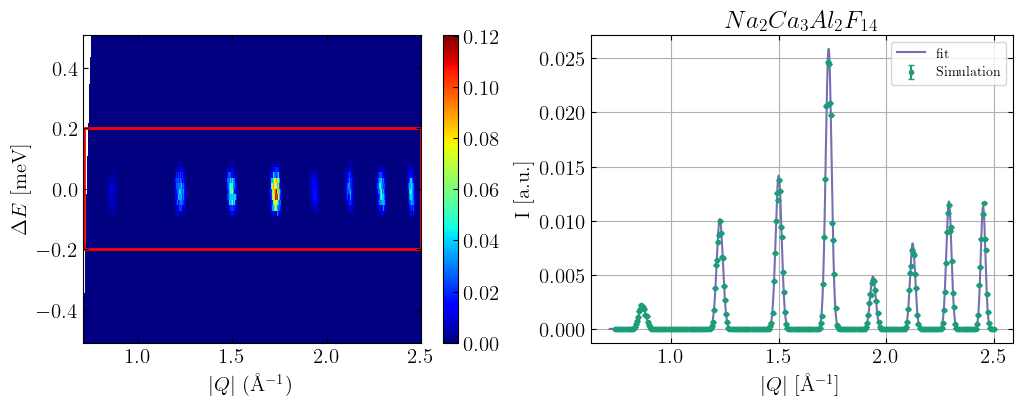

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].pcolormesh(p_bla.coords['Q'].values, p_bla.coords['deltaE'].values, p_bla.values, cmap='jet')
cbar = plt.colorbar(im)
#cbar.set_label('I [a.u.]')
ax[0].set_xlabel('$|Q|$ (Å$^{-1}$)')
ax[0].set_ylabel('$\Delta E$ [meV]')
# Plot the rectangle using fill_between
ax[0].fill_between([min(Q), 2.5], -0.2, 0.2, color='none', edgecolor='red', lw=2)


q_range = np.linspace(min(Q), max(Q), 10000)
ax[1].errorbar(Q, p7.values, p7.variances, fmt='.', label='Simulation')
ax[1].plot(q_range, gaussN(q_range, *pow_fit.values), '-', label='fit')
ax[1].set_title('$Na_2Ca_3Al_2F_{14}$')
ax[1].legend(fontsize=10)
ax[1].set_xlabel('$|Q|$ [Å$^{-1}$]')
ax[1].set_ylabel('I [a.u.]')
ax[1].grid()

#p7.plot(title='$Na_2Ca_3Al_2F_{14}$',  ax=ax[1])

plt.savefig('powder_NAC_bins_corrected.pdf', format='pdf', bbox_inches='tight')

In [8]:
values_dict = np.array([*pow_fit.values])
names = np.array(['A1', 'mu1', 'sigma1',
             'A2', 'mu2', 'sigma2',
             'A3', 'mu3', 'sigma3',
             'A4', 'mu4', 'sigma4',
             'A5', 'mu5', 'sigma5',
             'A6', 'mu6', 'sigma6',
             'A7', 'mu7', 'sigma7',
             'A8', 'mu8', 'sigma8'])


# Create LaTeX table header
latex_table = "\\begin{table}[htbp]\n"
latex_table += "\\centering\n"
latex_table += "\\begin{tabular}{|c|c|c|}\n"
latex_table += "\\hline\n"
latex_table += "Parameter Name & Fit Value & Fitting Error \\\\ \\hline\n"

# Add parameter values and errors to the LaTeX table
for i in range(len(values_dict)):
    error = pow_fit.errors[i]
    latex_table += f"\{names[i]} & {values_dict[i]:.3f} & {error:.3f} \\\\ \\hline\n"

# Close LaTeX table
latex_table += "\\end{tabular}\n"
latex_table += "\\caption{Fit parameters and errors}\n"
latex_table += "\\label{tab:fit_params}\n"
latex_table += "\\end{table}"

# Print LaTeX code for the table
print(latex_table)


\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Parameter Name & Fit Value & Fitting Error \\ \hline
\A1 & 0.002 & 0.000 \\ \hline
\mu1 & 0.866 & 0.000 \\ \hline
\sigma1 & 0.016 & 0.000 \\ \hline
\A2 & 9.900 & 0.000 \\ \hline
\mu2 & 1.201 & 0.000 \\ \hline
\sigma2 & 0.000 & 0.000 \\ \hline
\A3 & 0.014 & 0.000 \\ \hline
\mu3 & 1.499 & 0.000 \\ \hline
\sigma3 & 0.014 & 0.000 \\ \hline
\A4 & 0.026 & 0.000 \\ \hline
\mu4 & 1.731 & 0.000 \\ \hline
\sigma4 & 0.014 & 0.000 \\ \hline
\A5 & 0.005 & 0.000 \\ \hline
\mu5 & 1.937 & 0.000 \\ \hline
\sigma5 & 0.013 & 0.000 \\ \hline
\A6 & -16.114 & 0.000 \\ \hline
\mu6 & 2.193 & 0.000 \\ \hline
\sigma6 & 0.001 & 0.000 \\ \hline
\A7 & 0.012 & 0.000 \\ \hline
\mu7 & 2.290 & 0.000 \\ \hline
\sigma7 & 0.012 & 0.000 \\ \hline
\A8 & 0.011 & 0.000 \\ \hline
\mu8 & 2.449 & 0.000 \\ \hline
\sigma8 & 0.011 & 0.000 \\ \hline
\end{tabular}
\caption{Fit parameters and errors}
\label{tab:fit_params}
\end{table}


Text(0, 0.5, 'I [a.u.]')

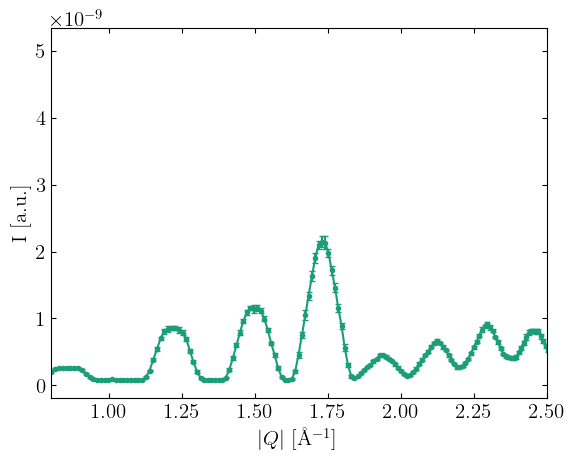

In [9]:
pow_ref = np.loadtxt('monitor_nd_NAC_reference.th_y').reshape(3,-1,270)

twotheta = np.linspace(30,165,270)
lam = 1/(0.11056*np.sqrt(5))
k = (2*np.pi)/lam
Q = 2*k*np.sin(np.radians(twotheta/2))

# Calculate weighted mean along a certain axis
weighted_mean_values = np.average(pow_ref[0], axis=0, weights=pow_ref[1])

# Calculate weighted standard deviation along a certain axis
weighted_std_values = np.sqrt(np.average((pow_ref[0] - weighted_mean_values)**2, axis=0, weights=pow_ref[1]))

plt.errorbar(Q, weighted_mean_values, weighted_std_values, fmt='.-')
plt.xlabel(r'$|Q|$ [Å$^{-1}$]')
plt.xlim(min(Q), 2.5)
plt.ylabel(r'I [a.u.]')